In [310]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torch.utils.data import Subset
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Load Data

375 32


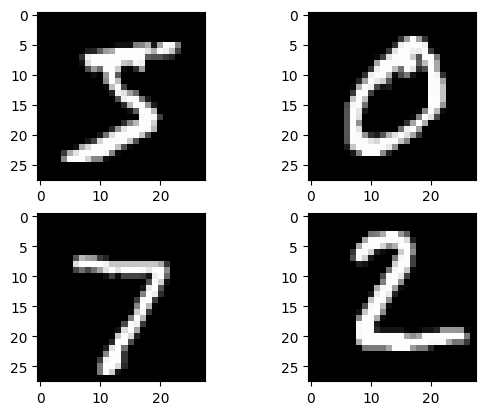

In [515]:

# download the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])
train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# plot samples
num_samples = 2
sample_train = train.data[:num_samples]
sample_test = test.data[:num_samples]

fig, axs = plt.subplots(2, num_samples)
for i, sample in enumerate(sample_train):
    axs[0, i].imshow(sample.numpy(), cmap='gray')
for i, sample in enumerate(sample_test):
    axs[1, i].imshow(sample.numpy(), cmap='gray')

subset_size = int(0.2 * len(train))
indices = torch.randperm(len(train))[:subset_size]
train = Subset(train, indices)
subset_size = int(0.1 * len(test))
indices = torch.randperm(len(test))[:subset_size]
test = Subset(test, indices)    

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
print(len(train_loader), len(test_loader))

# Define Noising Function

In [482]:
def generate_noise_progression(alpha_t, X, times):
    assert times.shape[0] == X.shape[0]
    epsilon = torch.randn(X.shape).to(X.device) 
    alpha_hat_t = (alpha_t ** times).view(-1, 1, 1, 1)
    return torch.sqrt(alpha_hat_t) * X + (epsilon * torch.sqrt(1 - alpha_hat_t))

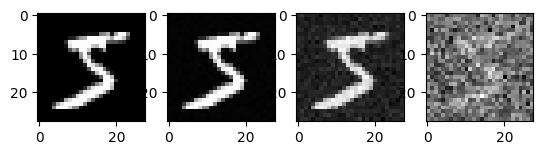

In [535]:
times = [0, 100, 500, 1000]
noised_sample = generate_noise_progression(0.99, sample_train[0].unsqueeze(0).repeat(len(times), 1,1, 1), torch.tensor(times))
fig, axs = plt.subplots(1, len(times))
for i, sample in enumerate(noised_sample):
    (axs[i].imshow
     (sample[0].numpy(), cmap='gray'))

# Define Model

In [542]:
model = (UNet2DModel(in_channels=1, out_channels=1, act_fn="gelu", block_out_channels=(32, 64, 96, 128)).to(device))

Iteration 0, Loss 0.18919585645198822
Iteration 1, Loss 0.15440765023231506
Iteration 2, Loss 0.13559389114379883
Iteration 3, Loss 0.1316131353378296
Iteration 4, Loss 0.11533550918102264
Iteration 5, Loss 0.11978858709335327
Iteration 6, Loss 0.10273265838623047
Iteration 7, Loss 0.11415652930736542
Iteration 8, Loss 0.0985267162322998
Iteration 9, Loss 0.08849737048149109
Iteration 10, Loss 0.0927688479423523
Iteration 11, Loss 0.08799227327108383
Iteration 12, Loss 0.09070910513401031
Iteration 13, Loss 0.08690851926803589
Iteration 14, Loss 0.08473725616931915
Iteration 15, Loss 0.08171632140874863
Iteration 16, Loss 0.07486540079116821
Iteration 17, Loss 0.07124443352222443
Iteration 18, Loss 0.07284747064113617
Iteration 19, Loss 0.06614023447036743
Iteration 20, Loss 0.06838124990463257
Iteration 21, Loss 0.07139140367507935
Iteration 22, Loss 0.07085438072681427
Iteration 23, Loss 0.06522876024246216
Iteration 24, Loss 0.06719878315925598
Iteration 25, Loss 0.06490640342235565

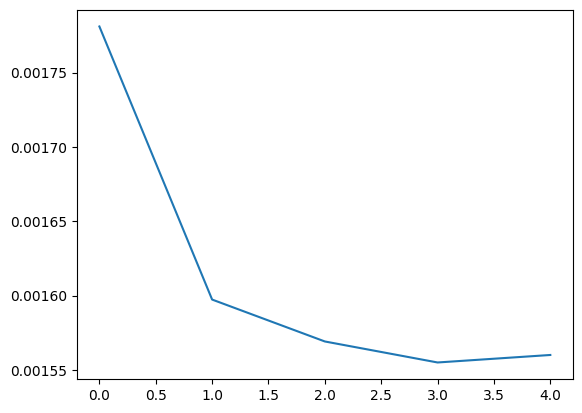

In [543]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)
    
num_epochs = 5
T = 1000
alpha_t = 0.99

train_loss_evolution = []
for epoch in range(num_epochs):
    train_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        times = torch.randint(2, T, size=(x.shape[0],)).to(device)
        noised_x = generate_noise_progression(alpha_t, x, times)
        x_hat = model(noised_x, times).sample
        
        loss = F.mse_loss(x_hat, x)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        print("Iteration {}, Loss {}".format(i, loss.item()))
    train_loss_evolution.append(train_loss / len(train))
    print(f'Epoch {epoch + 1} loss: {train_loss / len(train)}')
    
plt.plot(train_loss_evolution)
    
        
        
    

# Test

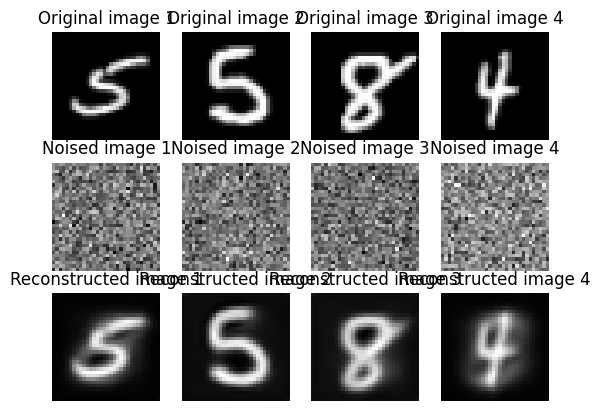

Iteration 0, Loss 0.01572161540389061
Iteration 1, Loss 0.018343200907111168
Iteration 2, Loss 0.0155312055721879
Iteration 3, Loss 0.015005487948656082
Iteration 4, Loss 0.019209695979952812
Iteration 5, Loss 0.016255028545856476
Iteration 6, Loss 0.020666509866714478
Iteration 7, Loss 0.016615252941846848
Iteration 8, Loss 0.01904219202697277
Iteration 9, Loss 0.02078118547797203
Iteration 10, Loss 0.015612233430147171
Iteration 11, Loss 0.02066802605986595
Iteration 12, Loss 0.017177585512399673
Iteration 13, Loss 0.016311142593622208
Iteration 14, Loss 0.016244344413280487
Iteration 15, Loss 0.0219966359436512
Iteration 16, Loss 0.015399549156427383
Iteration 17, Loss 0.016535762697458267
Iteration 18, Loss 0.018118396401405334
Iteration 19, Loss 0.018444456160068512
Iteration 20, Loss 0.01822122000157833
Iteration 21, Loss 0.017327863723039627
Iteration 22, Loss 0.02052229829132557
Iteration 23, Loss 0.018354976549744606
Iteration 24, Loss 0.015570602379739285
Iteration 25, Loss 0

In [544]:
test_loss = 0
num_images = 4
fig, axs = plt.subplots(3, num_images)
model.eval()
for i, (x, _) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        times = torch.randint(2, T, size=(x.shape[0],)).to(device)
        noised_x = generate_noise_progression(alpha_t, x, times)
        x_hat = model(x, times).sample
        loss = F.mse_loss(x_hat, x)
        test_loss += loss.item()
        if i == 0:
            x = x.detach().cpu().squeeze()
            noised_x = noised_x.detach().cpu().squeeze()
            x_hat = x_hat.detach().cpu().squeeze()
            for idx, ax in enumerate(axs[0]):
                ax.imshow(x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Original image {idx + 1}')
            for idx, ax in enumerate(axs[1]):
                ax.imshow(noised_x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Noised image {idx + 1}')
            for idx, ax in enumerate(axs[2]):
                ax.imshow(x_hat[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Reconstructed image {idx + 1}')
            plt.show()
    print("Iteration {}, Loss {}".format(i, loss.item()))
print(f'Test loss: {test_loss / len(test)}')
    

# Generate

In [545]:
generated_images = []
num_images = 100
with torch.no_grad():
    x_t = torch.randn([num_images, 1, 32, 32]).to(device)
    for t in reversed(range(2, T)):
        timestep = torch.tensor([t]).repeat(num_images).to(device)
        x_theta = model(x_t, timestep).sample
        alpha_bar_t = (alpha_t ** timestep).view(-1, 1, 1, 1)
        alpha_bar_t_1 = alpha_t ** (timestep-1).view(-1, 1, 1, 1)
        sqrt_alpha_t = torch.sqrt(torch.tensor(alpha_t).view(-1, 1, 1, 1)).to(device)
        mu_theta = 1 / (1 - alpha_bar_t) * (sqrt_alpha_t * (1 - alpha_bar_t_1) * x_t + torch.sqrt(alpha_bar_t_1) * (1 - alpha_t) * x_theta)
        x_t = mu_theta + ((1 - alpha_t) * (1 - alpha_bar_t_1) / (1 - alpha_bar_t)) * torch.randn(num_images).view(-1, 1, 1, 1).to(device)
    generated_images = x_t.detach().cpu().squeeze().squeeze().numpy()

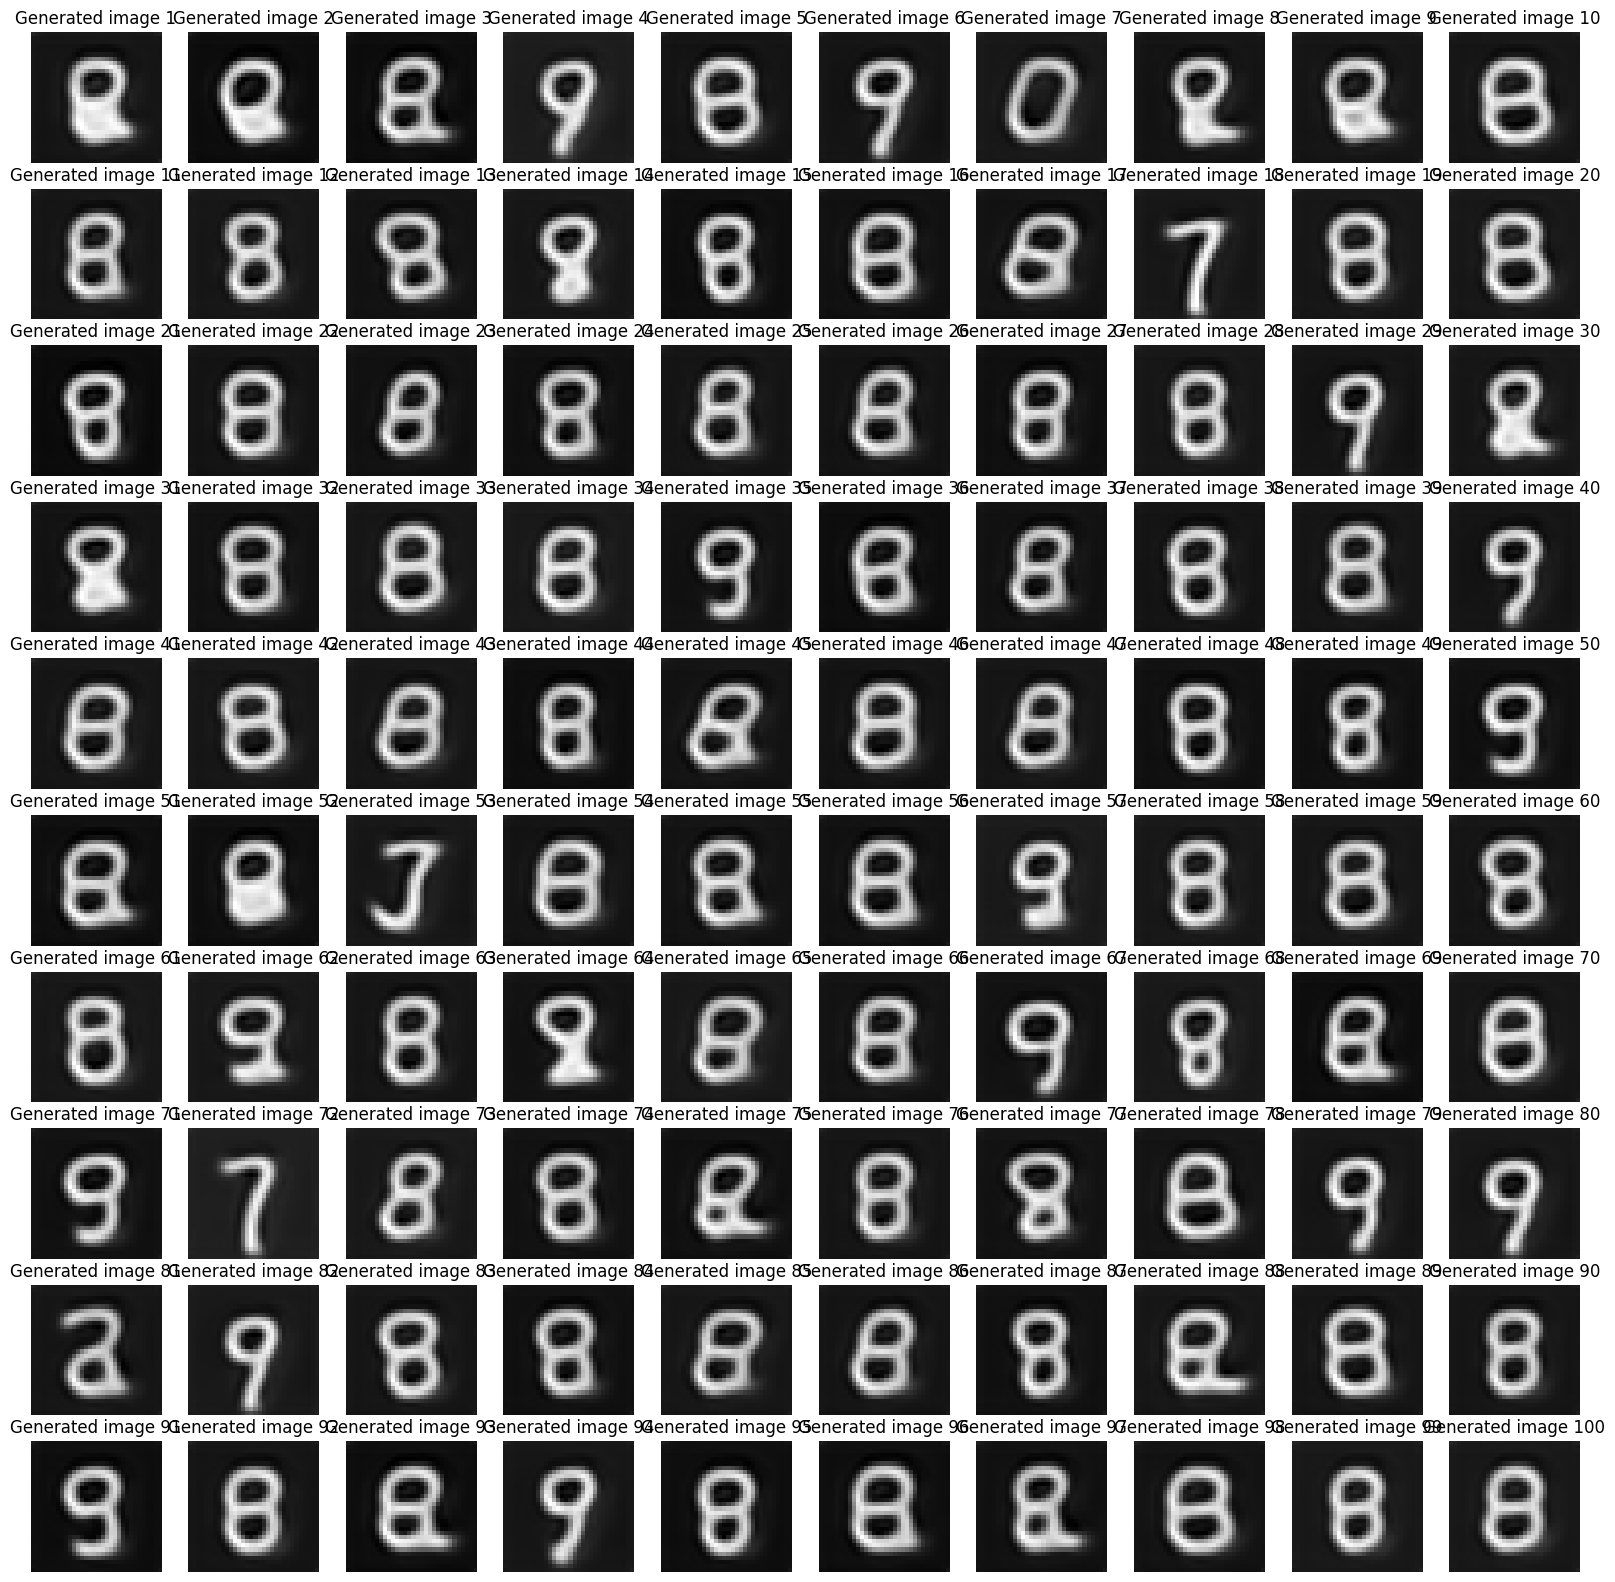

In [546]:
# Visualize the output

fig, axes = plt.subplots(nrows=10, ncols=int(num_images/10), figsize=(20, 20))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Generated image {idx + 1}')
plt.show()